### Load Libraries

In [1]:
# !pip install -Uqq fastai
# !pip install -Uqq lmfit

In [2]:
# !pip install -Uqq torch
# !pip install -Uqq fast-tabnet


In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

### Load the Data

In [4]:
SpecimenCompressionTestResult = pd.read_excel('SpecimenCompressionTestResult.xlsx')
SpecimenFieldReport = pd.read_excel('SpecimenFieldReport.xlsx')
ProjectInformation = pd.read_excel('ProjectInformationUpdated.xlsx')


### Merge the Data

In [5]:
# Merge SpecimenFieldReport and ProjectInformation
SpecimenFieldReport_new = SpecimenFieldReport.merge(ProjectInformation[['StructureType'
                                                        , 'StructureNumberLevels'
                                                        , 'StructureHeight'
                                                        , 'SiteLattitude '
                                                        , 'SiteLongitude'
                                                        ,'ProjectID']]
                          , on = 'ProjectID', how = 'left')

# Now merge it with SpecimenCompressionTestResult
Model_DF = SpecimenCompressionTestResult.merge(SpecimenFieldReport_new[['SiteTemperature'
                                                        , 'SiteWeather'
                                                        , 'BatchLabID'
                                                        ,  'BatchTimeMolded'
                                                        , 'BatchSpecimenSize'
                                                        , 'BatchTemperature'
                                                        , 'BatchUnitWeight'
                                                        , 'BatchRequiredStrength'
                                                        , 'StructureType'
                                                        , 'StructureNumberLevels'
                                                        , 'StructureHeight'
                                                        , 'SiteLattitude '
                                                        , 'SiteLongitude']]
                          , on = 'BatchLabID', how = 'left')

# Look at the top 4 rows
Model_DF.head(4)

,BatchLabNumber,ReportDateIssued,SpecimenAgeTested,SpecimenDateTested,SpecimenMeasuredStrength,BatchLabID,CylinderTestID,SiteTemperature,SiteWeather,BatchTimeMolded,BatchSpecimenSize,BatchTemperature,BatchUnitWeight,BatchRequiredStrength,StructureType,StructureNumberLevels,StructureHeight,SiteLattitude,SiteLongitude
0,12285,2022-07-07,7,2022-06-16,9860,54abcd3a-473e-4897-9cb2-1a890cc89c88,1,79.0,Clear,2022-06-09 12:53:00,4X8,89.0,149.6,8000,Residential,34,418.375,36.161455,-86.7848
1,12285,2022-07-07,28,2022-07-07,10360,54abcd3a-473e-4897-9cb2-1a890cc89c88,2,79.0,Clear,2022-06-09 12:53:00,4X8,89.0,149.6,8000,Residential,34,418.375,36.161455,-86.7848
2,12285,2022-07-07,28,2022-07-07,10300,54abcd3a-473e-4897-9cb2-1a890cc89c88,3,79.0,Clear,2022-06-09 12:53:00,4X8,89.0,149.6,8000,Residential,34,418.375,36.161455,-86.7848
3,12285,2022-07-07,28,2022-07-07,10140,54abcd3a-473e-4897-9cb2-1a890cc89c88,4,79.0,Clear,2022-06-09 12:53:00,4X8,89.0,149.6,8000,Residential,34,418.375,36.161455,-86.7848


### Subset and Prepare the data

In [6]:
# Subset the data and select only the required columns
Model_DF_Sub = Model_DF[['ReportDateIssued', 'SpecimenAgeTested', 'SpecimenDateTested', 'SpecimenMeasuredStrength'
                         , 'StructureType',  'SiteTemperature',  'BatchTimeMolded', 'BatchSpecimenSize'
                         , 'BatchTemperature' , 'BatchUnitWeight' , 'BatchRequiredStrength'
                         , 'StructureNumberLevels' , 'StructureHeight' , 'SiteLattitude ' , 'SiteLongitude' ]].copy()

# Create three new fields for Batch Molded Date,hour, and minute
Model_DF_Sub['BatchDateMolded'] = Model_DF_Sub['BatchTimeMolded'].dt.date
Model_DF_Sub['BatchHourMolded'] = Model_DF_Sub['BatchTimeMolded'].dt.hour
Model_DF_Sub['BatchMinutesMolded'] = Model_DF_Sub['BatchTimeMolded'].dt.minute


# Subset it further to remove the redundant columns
Model_DF_new = Model_DF_Sub[['SpecimenAgeTested', 'SpecimenMeasuredStrength'
                         , 'SiteTemperature', 'BatchTemperature' , 'BatchUnitWeight' 
                         , 'BatchRequiredStrength', 'StructureNumberLevels' , 'StructureHeight' 
                         , 'SiteLattitude ' , 'SiteLongitude' , 'BatchHourMolded', 'BatchMinutesMolded']]

# Drop Null values
Model_DF_new = Model_DF_new.dropna()

# Change Data types and do some data cleaning
Model_DF_new['BatchMinutesMolded'] = Model_DF_new['BatchMinutesMolded'].astype('int')
Model_DF_new['BatchHourMolded'] = Model_DF_new['BatchHourMolded'].astype('int')
Model_DF_new['BatchRequiredStrength'] = Model_DF_new['BatchRequiredStrength'].astype(str)
Model_DF_new['BatchRequiredStrength'] = Model_DF_new['BatchRequiredStrength'].replace(r'[^0-9]', '', regex=True)
Model_DF_new['BatchRequiredStrength'] = Model_DF_new['BatchRequiredStrength'].astype('int')
Model_DF_new['SiteLongitude'] = Model_DF_new['SiteLongitude'].astype('float')

# Subset the data for only 7,28 and 56 days
Model_DF_new = Model_DF_new[Model_DF_new["SpecimenAgeTested"].isin([7, 28, 56])].reset_index(drop=True)
#Model_DF_new = Model_DF_new[Model_DF_new["SpecimenMeasuredStrength"] < 16000].reset_index(drop=True)

# Export this data as csv 
#Model_DF_new.to_csv('Model_Data.csv', index=False)

# Look at the top 4 rows of this dataset
Model_DF_new.head(4)         

,SpecimenAgeTested,SpecimenMeasuredStrength,SiteTemperature,BatchTemperature,BatchUnitWeight,BatchRequiredStrength,StructureNumberLevels,StructureHeight,SiteLattitude,SiteLongitude,BatchHourMolded,BatchMinutesMolded
0,7,9860,79.0,89.0,149.6,8000,34,418.375,36.161455,-86.7848,12,53
1,28,10360,79.0,89.0,149.6,8000,34,418.375,36.161455,-86.7848,12,53
2,28,10300,79.0,89.0,149.6,8000,34,418.375,36.161455,-86.7848,12,53
3,28,10140,79.0,89.0,149.6,8000,34,418.375,36.161455,-86.7848,12,53


In [7]:
Model_DF_new.groupby(['SiteLattitude '])['SiteLattitude '].count()

SiteLattitude 
36.161263     750
36.161455    1302
41.429539     420
Name: SiteLattitude , dtype: int64

### Get Started with the Model

In [8]:
# Import the fast ai library
from fastai.tabular.all import *

In [9]:
# Set random state for reproducability of the results
np.random.seed(123)

# Split the data  between test (20%) and train (80%)

index = np.random.rand(len(Model_DF_new)) < 0.8
train_df = Model_DF_new[index].copy()
test_df = Model_DF_new[~index].copy()

# scale y variable to natural log since the range is huge
train_df['SpecimenMeasuredStrength'] = np.log(train_df['SpecimenMeasuredStrength'])

#### Create Aritifical Nueral Network With FastAi Tabular

In [146]:
# Split your training set into training and validation (to evaluate on the unseen data)
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

# Define the your Datablock
to = TabularPandas(train_df, procs=[Categorify, Normalize],
                   cat_names = ['SpecimenAgeTested'],
                   cont_names = list(train_df.drop(columns=['SpecimenMeasuredStrength', 'SpecimenAgeTested']).columns.values),
                   y_names='SpecimenMeasuredStrength',
                   y_block=RegressionBlock(),
                   splits=splits)

# Define your batch size in your dataloader
dls = to.dataloaders(bs=64)

# Define Network for your Model
learn = tabular_learner(dls, metrics= [rmse]
                        , layers=[300,200,100,50]
                        , opt_func=Adam)

#learn.summary()

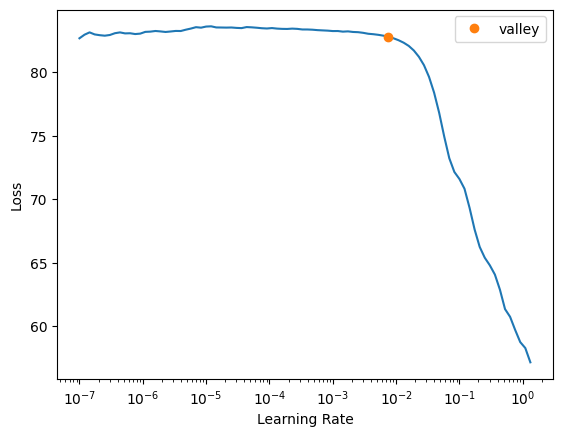

In [147]:
# Find the Learning Rate
valley  = learn.lr_find()

In [148]:
# Train your Model for the 23 epochs (cycles)
learn.fit_one_cycle(23 ,valley[0])

epoch,train_loss,valid_loss,_rmse,time
0,82.797020,82.402153,9.077563,00:00
1,81.435631,80.737663,8.985414,00:00
2,75.503098,61.790413,7.860688,00:00
3,55.966942,12.832235,3.582211,00:00
4,32.982288,0.508727,0.713251,00:00
5,19.650410,0.101556,0.318679,00:00
6,11.864372,0.066749,0.258358,00:00
7,7.232322,0.088777,0.297955,00:00
8,4.440492,0.040010,0.200025,00:00
9,2.738282,0.047438,0.217802,00:00


In [149]:
# The exp of RMSE value
learn.recorder.values[-1][2]

0.13347852230072021

#### Function to get Importance Plot

In [150]:
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df
    bs = bs if bs is not None else learn.dls.bs
    if self.df is not None:
      self.dl = learn.dls.test_dl(self.df, bs=bs)
    else:
      self.dl = learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))
     
     # Reference : https://walkwithfastai.com/Regression_and_Permutation_Importance

Getting base error


Calculating Permutation Importance


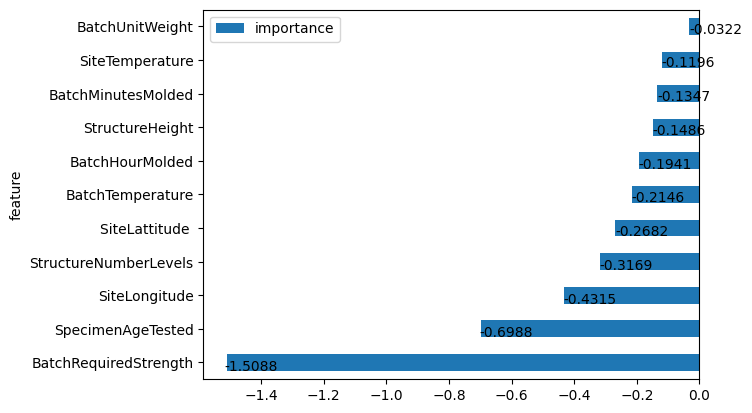

In [151]:
# Get the Importance plot for your trained network
res = PermutationImportance(learn, train_df.iloc[:], bs=64)

#### Display it as % of total importance

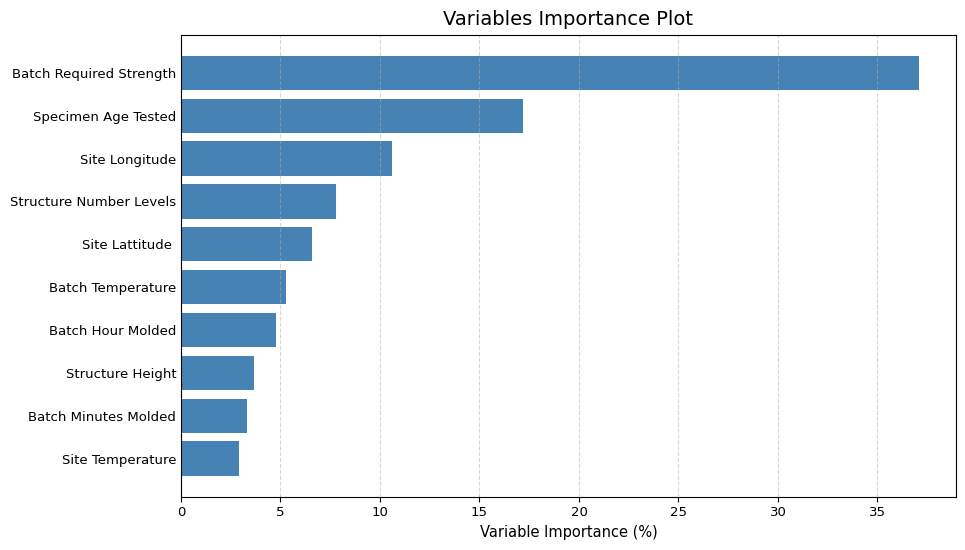

In [154]:
# Store the results in a dictionary
dict_var_imp = res.importance

# calculate the percentage of total and sort in descending order
total = sum(dict_var_imp.values())

# Create a Dataframe to store the values
var_imp_df = pd.DataFrame({'Variable': list(dict_var_imp.keys()), 'Importance': list(dict_var_imp.values())})
var_imp_df['Pct_Total'] = (var_imp_df['Importance'] / total * 100).round(2)
var_imp_df = var_imp_df.sort_values(by='Pct_Total', ascending=False).reset_index(drop=True)

# Add a space before the capital letter in each word of the Variable column except the first letter
var_imp_df['Variable'] = var_imp_df['Variable'].apply(lambda x: re.sub(r'([a-z])([A-Z])', r'\1 \2', x))

# Get the top 10 Variables
#top_10 = var_imp_df.head(10)

# Create bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_10['Variable'][::-1]
         , top_10['Pct_Total'][::-1]
         , color='steelblue')


plt.xlabel('Variable Importance (%)', fontsize=10.5)
plt.title('Variables Importance Plot' 
          , fontsize=14
          , loc = 'center'
          , pad = 7)

plt.xticks(fontsize=9.5)  
plt.yticks(fontsize=9.5) 
plt.tick_params(axis='y', length=0)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.savefig('var_imp_plot.png', bbox_inches='tight');   # Export the image as .png file

#### Export the Model

In [155]:
learn.export('DCE_predictive_model.pkl')

#### Load the Model

In [156]:
# load the saved model
learn = load_learner('DCE_predictive_model.pkl')

# Get the Model's prediction on Test Data
test_dl = learn.dls.test_dl(test_df)
preds, _  = learn.get_preds(dl=test_dl)

In [157]:
# See the actual values and prediction values
Result_comparison = pd.concat([test_df['SpecimenAgeTested'].reset_index(drop=True)
           , test_df['SpecimenMeasuredStrength'].reset_index(drop=True)
           , pd.DataFrame(np.around(np.exp(preds)), columns=['SpecimenMeasuredStrength_pred'])
           , test_df['BatchRequiredStrength'].reset_index(drop=True)], axis=1)

#Result_comparison['Actual Ratio'] = Result_comparison['SpecimenMeasuredStrength'] / Result_comparison['BatchRequiredStrength']
#Result_comparison['Predicted Ratio'] = Result_comparison['SpecimenMeasuredStrength_pred'] / Result_comparison['BatchRequiredStrength']

Result_comparison

,SpecimenAgeTested,SpecimenMeasuredStrength,SpecimenMeasuredStrength_pred,BatchRequiredStrength
0,7,6300,7044.0,7200
1,28,8950,9074.0,7200
2,28,8950,8331.0,6500
3,28,8690,8989.0,7200
4,28,12000,10946.0,10000
...,...,...,...,...
501,28,4220,5012.0,4000
502,7,3300,3496.0,4000
503,28,4810,5355.0,4000
504,28,4660,5336.0,4000


In [158]:
# Export these Results
#Result_comparison.to_csv('test_pred.csv', index=False)

#### Calculate the Test RMSE

In [159]:
from sklearn.metrics import mean_squared_error

pred_array = np.around(np.exp(preds)).numpy().flatten()
true_value_array = test_df['SpecimenMeasuredStrength'].to_numpy()
test_rmse = mean_squared_error(true_value_array, pred_array, squared=False)

print("Test RMSE is :", test_rmse)

Test RMSE is : 1022.0803370650566


**Prediction Values are off by 1022 PSI**